Import libraries

In [1]:
!pip install -q tensorflow fredapi matplotlib plotly keras keras-tuner yfinance

from fredapi import Fred
import yfinance as yf

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
import time
from matplotlib.ticker import MaxNLocator

Train LSTM model and plot predictions

C:\Users\emman\AppData\Local\Temp\ipykernel_75624\3383459325.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker_symbol, start=startday, end=endday, progress=False)


[NVDA] Test RMSE: 1.0946 | MAE: 0.8391


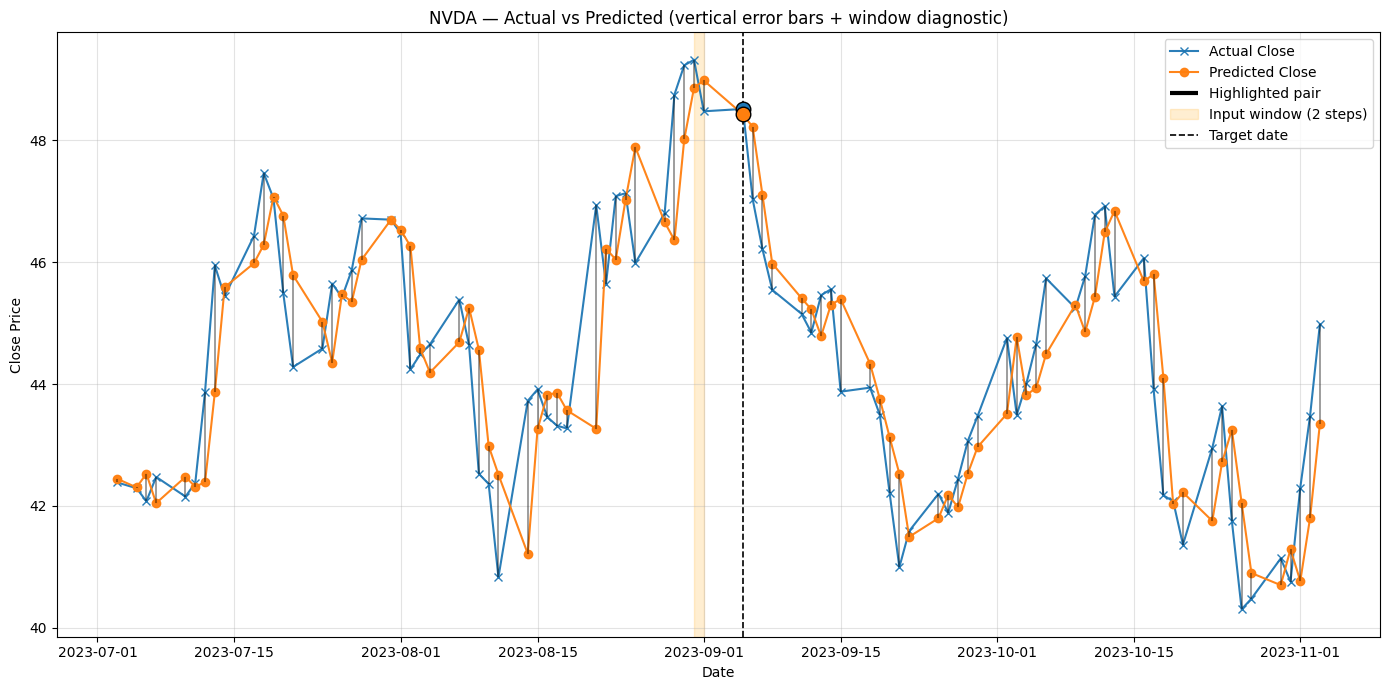

In [5]:
# --- Imports ---
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# --- Parameters ---
seq_length = 2           # sliding window length
target = 'Close'         # prediction target column
dayspan = 90             # last N days reserved for test
ticker = 'NVDA'
start_date = '2022-01-01'
end_date   = '2023-11-05'

# --- Fetch & process data ---
def getData(ticker_symbol, startday, endday):
    """
    Downloads OHLCV data from yfinance, computes Daily_Return (%), fills NAs.
    """
    df = yf.download(ticker_symbol, start=startday, end=endday, progress=False)
    df['Daily_Return'] = df['Close'].pct_change() * 100
    df = df.bfill().dropna()
    return df

# --- Create supervised sequences ---
def create_sequences(X, y, seq_len: int):
    """
    Build sliding windows of length `seq_len` from X and the label at t+seq_len from y.
    X: (N, n_features), y: (N, 1) scaled arrays
    Returns:
      X_seq: (N - seq_len, seq_len, n_features)
      y_seq: (N - seq_len, 1)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i + seq_len])
        ys.append(y[i + seq_len])   # y is (N,1), yields shape (1,)
    return np.array(Xs), np.array(ys)

# --- Load data ---
data = getData(ticker, start_date, end_date)

# --- Train/Test split ---
train = data.iloc[:-dayspan].copy()
test  = data.iloc[-dayspan:].copy()

# --- Features & target ---
features = train.columns.tolist()   # use all columns in train (incl. Daily_Return)
target_col = target

# --- Scale (fit on train only) ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train[features].values)
y_train = scaler_y.fit_transform(train[[target_col]].values)  # (N,1)

X_test  = scaler_X.transform(test[features].values)
y_test  = scaler_y.transform(test[[target_col]].values)

# --- Build sequences ---
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  seq_length)

# --- Model ---
model = Sequential([
    Input(shape=(seq_length, len(features))),
    LSTM(75),
    Dense(64, activation='relu'),
    Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10_000,
    batch_size=128,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=0
)

# --- Predict & inverse-scale ---
y_pred_scaled = model.predict(X_test_seq, verbose=0)            # (M,1)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()       # (M,)
y_true = scaler_y.inverse_transform(y_test_seq).ravel()          # (M,)

# --- Metrics ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
print(f"[{ticker}] Test RMSE: {rmse:.4f} | MAE: {mae:.4f}")

# ========= Single Graph: Actual vs Predicted + Connectors + Window Diagnostic =========

# 1) Map each prediction to the correct date on the test index
pred_dates = test.index[seq_length:]   # each pred corresponds to test[t+seq_length]
assert len(pred_dates) == len(y_true) == len(y_pred), "Alignment lengths mismatch"

# 2) Choose one prediction to highlight (midpoint by default)
k_mark = len(pred_dates) // 2 if len(pred_dates) > 0 else 0

# For the highlighted prediction i=k_mark:
# - input window uses test indices [i .. i+seq_length-1]
# - target (predicted) date is test index at i+seq_length
win_start = k_mark
target_idx = k_mark + seq_length

# Guard if test is too short
if target_idx < len(test.index):
    win_dates   = test.index[win_start: win_start + seq_length]  # length = seq_length
    target_date = test.index[target_idx]
    # Sanity check: the target_date must be the same as the plotted pred_dates[k_mark]
    assert target_date == pred_dates[k_mark], "Target date misaligned with pred_dates!"

# 3) Plot everything on ONE figure
fig, ax = plt.subplots(figsize=(14, 7))

# Series
ax.plot(pred_dates, y_true, marker='x', linestyle='-', label='Actual Close', alpha=0.95)
ax.plot(pred_dates, y_pred, marker='o', linestyle='-', label='Predicted Close', alpha=0.95)

# Vertical connectors (black, darker for clarity)
for d, yt, yp in zip(pred_dates, y_true, y_pred):
    ax.vlines(d, ymin=min(yt, yp), ymax=max(yt, yp), color='black', alpha=0.45, lw=1.2)

# Highlight the chosen day: thicker black connector + emphasized markers
if len(pred_dates) > 0:
    ax.vlines(pred_dates[k_mark], y_true[k_mark], y_pred[k_mark],
              color='black', lw=3.0, label='Highlighted pair')
    ax.scatter(pred_dates[k_mark], y_true[k_mark], s=110, edgecolor='black', zorder=3)
    ax.scatter(pred_dates[k_mark], y_pred[k_mark], s=110, edgecolor='black', zorder=3)

# Shade the input window and draw a thin black line at the target date (diagnostic)
if target_idx < len(test.index):
    ax.axvspan(win_dates[0], win_dates[-1], color='orange', alpha=0.18,
               label=f'Input window ({seq_length} steps)')
    ax.axvline(target_date, color='black', linestyle='--', lw=1.2, label='Target date')

# Cosmetics
ax.set_title(f"{ticker} — Actual vs Predicted (vertical error bars + window diagnostic)")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.grid(True, which='both', alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()
